## Dataset

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

import keras
#import keras_cv

from tensorflow.keras.models import *
from tensorflow.keras.layers import *

2023-07-18 02:19:01.355800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 02:19:01.484580: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-18 02:19:01.512187: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
def cutout(image):
    H, W, C = image.shape
    image_cut = image.copy()
    
    count = np.random.randint(2)
    
    for _ in range(count):
        y = np.random.randint(H - 1)
        x = np.random.randint(W - 1)
        length = np.random.randint(low = W * 0.1, high = W * 0.3)

        y1 = np.clip(y - (length // 2), 0, H - 1)
        y2 = np.clip(y + (length // 2), 0, H - 1)
        x1 = np.clip(x - (length // 2), 0 ,W - 1)
        x2 = np.clip(x + (length // 2), 0, W - 1)

        image_cut[y1:y2, x1:x2, :] = 0
    
    return image_cut

def add_noise(img):
    img = img/255.0
    VARIABILITY = 0.1
    deviation = VARIABILITY * np.random.uniform()
    noise = np.random.normal(0, deviation, img.shape)
    img += noise
    img = np.clip(img, 0., 1.)
    return img

def mixup(x, y):
    rand = np.random.uniform()
    if(rand > 0.5):
        return x, y
    alpha = 1
    lam = np.random.beta(alpha, alpha)
    ori_index = np.arange(int(len(x)))
    index = np.random.permutation(ori_index)
    mixed_x = lam * x[ori_index] + (1 - lam) * x[index]
    mixed_y = lam * y[ori_index] + (1 - lam) * y[index]

    return mixed_x, mixed_y

def mixed_generator(generator):
    while True:
        batch_x, batch_y = next(generator)
        batch_x, batch_y = mixup(batch_x, batch_y)
        yield batch_x, batch_y

def preproc_func(img):
    img = add_noise(img)
    img = cutout(img)
    return img

In [4]:
def mixup_generator(generator):
    while True:
        batch_x, batch_y = next(generator)
        batch_x, batch_y = mix_up(batch_x, batch_y)
        yield batch_x, batch_y
        
def mix_up(batch_x, batch_y):
    ori_index = np.arange(int(len(batch_x)))
    index = np.random.permutation(ori_index)
    for i in range(len(ori_index)):
        H, W, _ = batch_x[ori_index[i]].shape
        if H == 224:
            y = np.random.randint(low = 60, high = 150)
            x = np.random.randint(low = 60, high = 150)
        if H == 299:
            y = np.random.randint(low = 60, high = 200)
            x = np.random.randint(low = 60, high = 200)
        
        length = np.random.randint(low = 25, high = 80)

        y1 = np.clip(y - (length // 2), 0, H - 1)
        y2 = np.clip(y + (length // 2), 0, H - 1)
        x1 = np.clip(x - (length // 2), 0 ,W - 1)
        x2 = np.clip(x + (length // 2), 0, W - 1)
        
        tmp = np.random.randint(2)
        
        if tmp == 0:
            batch_x[ori_index[i]][y1:y2, x1:x2, :] = batch_x[index[i]][0:y2-y1, 0:x2-x1, :]
        else:
            batch_x[ori_index[i]][y1:y2, x1:x2, :] = batch_x[index[i]][H-(y2-y1):H, W-(x2-x1): W, :]
    return batch_x, batch_y

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_generator = ImageDataGenerator(
    #rescale = 1/255.
     rotation_range = 15
    , shear_range = 0.15
    , zoom_range = 0.15
    , horizontal_flip = True
    , brightness_range=[0.9, 1.015]
    , preprocessing_function = add_noise
)

valid_generator = ImageDataGenerator(
    rescale=1/255.
)

In [6]:
train_dst = train_generator.flow_from_directory(
    directory = '/root/jupyter/backup/CUB_200_2011/images/train'
    , target_size = (224, 224)
    , batch_size = 16
    , class_mode = 'categorical'
    , shuffle = True
)

valid_dst = valid_generator.flow_from_directory(
    directory = '/root/jupyter/backup/CUB_200_2011/images/valid'
    , target_size = (224, 224)
    , batch_size = 16
    , class_mode = 'categorical'
    , shuffle = True
)

Found 10650 images belonging to 200 classes.
Found 1139 images belonging to 200 classes.


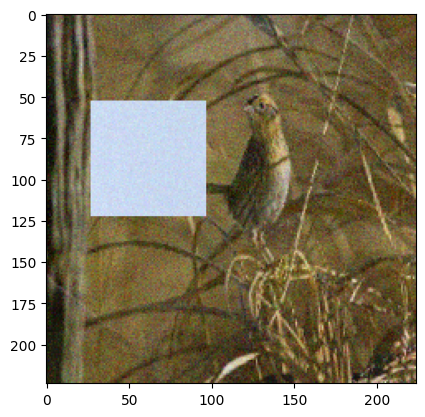

In [7]:
images, labels = next(train_dst)
dst = mixed_generator(train_dst)
dst = mixup_generator(dst)
images, labels = next(dst)
# print(labels)

plt.imshow(images[0])
plt.show()

# 모델이 여러 특성을 학습하도록 도와주고
# 동시에 배경이 쓸모 없는 정보임을 모델에게 학습시킴.


In [8]:
# Initialize step(mixup 할 때 설정 필요)

import os
# data_dir 디렉토리 아래의 모든 디렉토리와 파일을 탐색
# total_data = sum([len(files) for r, d, files in os.walk(data_dir)])
total_data = 11807
valid_data_rate = 0.1
batch_size = 16

total_train_data = total_data * (1 - valid_data_rate)
total_valdation_data = total_data * valid_data_rate

steps_per_epoch = total_train_data // batch_size
validation_steps = total_valdation_data // batch_size

## ResNet

In [40]:
import wandb

wandb.init(
    project="bird",
    name="ResNet50",
    config={
        "epochs": 100,
        "batch_size": 16,
        "config" : "label_smoothing, alpha_blending, cut_mix, bottleneck"
    }
)

accuracy,▁▁▁▂▂▂▃▃▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▇▇▆▆▅▅▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▃▃▃▄▄▄▅▅▆▆▆▆▇▇▇▇▇▇▆▇▇█▇▇█▇▇█▇▇▇▇█▇▇▇
val_loss,█▇▇▇▅▅▅▄▃▃▃▃▂▂▂▃▂▂▁▂▂▂▂▂▂▁▂▂▁▁▂▁▁▁▂▁▁▁▂▂
accuracy,0.69604
best_epoch,126
best_val_loss,2.43961
epoch,130
loss,2.45434
val_accuracy,0.51449


## ResNet50

In [41]:
def conv1x1(x, filters, strides = 1):
    x = Conv2D(filters, (1, 1), strides, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    return x

def conv3x3(x, filters, strides = 1):
    x = Conv2D(filters, (3, 3), strides, padding = 'same', kernel_initializer='he_normal')(x)
    x = SpatialDropout2D(0.3)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def residual_block_50(x, i, filters, fstrides = 2):
    shortcut = tf.identity(x)
    if i == 0:
        x = conv1x1(x, filters, strides = fstrides)
    else:
        x = conv1x1(x, filters)
    x = Activation('relu')(x)
    x = conv3x3(x, filters)
    x = conv1x1(x, filters * 4)
    if i == 0:
        shortcut = conv1x1(shortcut, filters * 4, fstrides)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    
    return x

In [42]:
inputs = Input(shape=(224, 224, 3))

x = ZeroPadding2D(padding=(3, 3))(inputs)
x = Conv2D(64, (7, 7), 2)(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((3, 3), 2)(x)

for i in range(3):
    x = residual_block_50(x, i, 64, 1)
    
for i in range(4):
    x = residual_block_50(x, i, 128)
    
for i in range(6):
    x = residual_block_50(x, i, 256)
    
for i in range(3):
    x = residual_block_50(x, i, 512)
    
x = GlobalAveragePooling2D()(x)

#x = Dense(1024, activation = 'relu')(x)

# x = LayerNormalization()(x)
#x = BatchNormalization()(x)
output = Dense(200, activation = 'softmax')(x)

resnet50 = Model(inputs, output)


In [43]:
initial_lr = 0.005
decay_rate = 0.95 
steps = 667
epochs = 50
decay_steps = (steps * epochs) * 0.1

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps, decay_rate
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [44]:
from keras.optimizers import Adam

resnet50.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              optimizer = optimizer,
              metrics = ['accuracy'])

resnet50.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_250 (Conv2D)            (None, 109, 109, 64  9472        ['input_9[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_222 (Batch  (None, 109, 109, 64  256        ['conv2d_250[0][0]']             
 Normalization)                 )                                                           

In [45]:
hist = resnet50.fit(
    dst,
    steps_per_epoch = steps_per_epoch,
    epochs = 100,
    verbose = 1,
    validation_data = valid_dst,
    callbacks = [wandb.keras.WandbCallback(save_model = False)]
)

Epoch 1/100
664/664 [==============================] - 163s 238ms/step - loss: 5.5734 - accuracy: 0.0051 - val_loss: 5.3022 - val_accuracy: 0.0053
Epoch 2/100
664/664 [==============================] - 159s 240ms/step - loss: 5.3099 - accuracy: 0.0047 - val_loss: 5.5295 - val_accuracy: 0.0105
Epoch 3/100
664/664 [==============================] - 159s 240ms/step - loss: 5.2665 - accuracy: 0.0095 - val_loss: 5.2878 - val_accuracy: 0.0149
Epoch 4/100
664/664 [==============================] - 158s 238ms/step - loss: 5.2020 - accuracy: 0.0107 - val_loss: 42.9337 - val_accuracy: 0.0070
Epoch 5/100
664/664 [==============================] - 158s 239ms/step - loss: 5.1511 - accuracy: 0.0115 - val_loss: 5.9040 - val_accuracy: 0.0132
Epoch 6/100
664/664 [==============================] - 157s 236ms/step - loss: 5.1182 - accuracy: 0.0136 - val_loss: 5.1781 - val_accuracy: 0.0167
Epoch 7/100
664/664 [==============================] - 158s 238ms/step - loss: 5.0992 - accuracy: 0.0127 - val_loss: 

## ResNet34(18)

In [31]:
import wandb

wandb.init(
    project="bird",
    name="ResNet18_mixup",
    config={
        "epochs": 100,
        "batch_size": 16,
        "config" : "label_smoothing, alpha_blending, mixup"
    }
)

accuracy,▁▃▄▆▅▇██▇▄▆▇
epoch,▁▂▂▃▄▄▅▅▆▇▇█
loss,█▂▁▁▁▁▁▁▂▁▁▁
val_accuracy,▂▂▅▁██▆▅▁▆▄▇
val_loss,█▁▁▅▁▁▁▁█▁▁▁
accuracy,0.02475
best_epoch,5
best_val_loss,5.12129
epoch,11
loss,5.14542
val_accuracy,0.02985


In [10]:
def conv3x3(x, filters, strides = 1):
    x = Conv2D(filters, (3, 3), strides, padding = 'same', kernel_initializer='he_normal')(x)
    x = SpatialDropout2D(0.2)(x)
    # x = GaussianNoise(0.1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x

def conv3x3_2(x, filters, strides = 1):
    x = Conv2D(filters, (3, 3), strides, padding = 'same', kernel_initializer = 'he_normal')(x)
    # x = SpatialDropout2D(0.2)(x)
    # x = GaussianNoise(0.1)(x)
    # x = BatchNormalization()(x)
    return x

def residual_block_34(x, i, filters, fstrides = 2):
    shortcut = tf.identity(x)
    if i == 0:
        x = conv3x3(x, filters)
        x = MaxPool2D()(x)
    else:
        x = conv3x3(x, filters)
    x = Conv2D(filters*4,1,1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters,3,1,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    if i == 0:
        shortcut = conv1x1(shortcut, filters)
        shortcut = MaxPool2D()(shortcut)
    x = Add()([x,shortcut])
    # x = ActivityRegularization(l2 = 0.01)(x)
    # if filters != 512 or i != 2:
    #     x = Activation('relu')(x)
    
    return x    

def conv1x1(x, filters, strides = 1):
    x = Conv2D(filters, (1, 1), strides)(x)
    # x = BatchNormalization()(x)
    return x

In [11]:
inputs = Input(shape=(224, 224, 3))

# x = ZeroPadding2D(padding=(3, 3))(inputs)
x = Conv2D(64, (7, 7), 1, padding='same')(inputs)
x = BatchNormalization()(x)
x = Activation('relu')(x)
# x = ZeroPadding2D(padding=(1, 1))(x)
x = MaxPooling2D((2, 2), 2)(x)

for i in range(2):
    x = residual_block_34(x, i, 64, 1)
    
for i in range(2):
    x = residual_block_34(x, i, 128)
    
for i in range(2):
    x = residual_block_34(x, i, 256)
    
for i in range(2):
    x = residual_block_34(x, i, 512)
    
x = GlobalAveragePooling2D()(x)


x = Dense(256)(x)
# x = BatchNormalization()(x)
# x = Activation('relu')(x)
output = Dense(200, activation = 'softmax')(x)

resnet18 = Model(inputs, output)

2023-07-18 02:19:16.295766: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 02:19:16.811263: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22283 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:65:00.0, compute capability: 8.6


In [12]:
initial_lr = 1e-3
decay_rate = 0.98
steps = 667
epochs = 100
decay_steps = (steps * epochs) * 0.1

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps, decay_rate
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [13]:
resnet18.compile(#loss = 'categorical_crossentropy',
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1),
              optimizer = optimizer,
              metrics = ['accuracy'])

resnet18.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  9472        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 224, 224, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

In [ ]:
hist = resnet18.fit(
    dst,
    steps_per_epoch = steps_per_epoch,
    epochs = 100,
    verbose = 1,
    validation_data = valid_dst,
    callbacks = [wandb.keras.WandbCallback(save_model = False)]
)

Epoch 1/100
664/664 [==============================] - 157s 237ms/step - loss: 2.4064 - accuracy: 0.7392 - val_loss: 2.8787 - val_accuracy: 0.5189
Epoch 2/100
664/664 [==============================] - 157s 237ms/step - loss: 2.2550 - accuracy: 0.7708 - val_loss: 2.7977 - val_accuracy: 0.5171
Epoch 3/100
664/664 [==============================] - 157s 237ms/step - loss: 2.2264 - accuracy: 0.7734 - val_loss: 2.7865 - val_accuracy: 0.5294
Epoch 4/100
664/664 [==============================] - 157s 236ms/step - loss: 2.1726 - accuracy: 0.7884 - val_loss: 2.8461 - val_accuracy: 0.5022
Epoch 5/100
664/664 [==============================] - 157s 236ms/step - loss: 2.2658 - accuracy: 0.7797 - val_loss: 2.8676 - val_accuracy: 0.5198
Epoch 6/100
664/664 [==============================] - 157s 237ms/step - loss: 2.2448 - accuracy: 0.7879 - val_loss: 2.7791 - val_accuracy: 0.5373
Epoch 7/100
664/664 [==============================] - 157s 236ms/step - loss: 2.2434 - accuracy: 0.7840 - val_loss: 2

## ResNet_V2

In [33]:
def Conv3(filters, x, fstrides = 1):
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, 3, padding = 'same', kernel_initializer = 'he_normal')(x)
    return x

def ResNetv2_block(filters, x, fstrides = 1):
    shortcut = tf.identity(x)
    if fstrides == 2:
        x = Conv3(filters, x)
        x = MaxPool2D((2,2),2)(x)
    else:
        x = Conv3(filters, x)
    
    x = Conv2D(filters//4,1,1)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv3(filters, x)
    
    if fstrides == 2:
        shortcut = Conv2D(filters, 1, kernel_initializer = 'he_normal')(shortcut)
        shortcut = MaxPool2D((2,2),2)(shortcut)
    x = Add()([x,shortcut])
    return x
    

inputs = Input(shape=(224, 224, 3))

x = Conv2D(64, (7, 7), 1, padding='same')(inputs)
x = MaxPooling2D((2, 2), 2)(x)

for i in range(2):
    x = ResNetv2_block(64, x)

for i in range(2):
    if i == 0:
        x = ResNetv2_block(128, x, 2)
    else:
        x = ResNetv2_block(128, x)

for i in range(2):
    if i == 0:
        x = ResNetv2_block(256, x, 2)
    else:
        x = ResNetv2_block(256, x)

for i in range(2):
    if i == 0:
        x = ResNetv2_block(512, x, 2)
    else:
        x = ResNetv2_block(512, x)

x = GlobalAveragePooling2D()(x)
output = Dense(200, activation = 'softmax')(x)


resnet18_v2 = Model(inputs,output)

In [34]:
initial_lr = 1e-3
decay_rate = 0.98
steps = 667
epochs = 100
decay_steps = (steps * epochs) * 0.1

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_lr, decay_steps, decay_rate
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

In [35]:
resnet18_v2.compile(loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
              optimizer = optimizer,
              metrics = ['accuracy'])

In [36]:
hist = resnet18_v2.fit(
    dst,
    steps_per_epoch = 667,
    epochs = 200,
    verbose = 1,
    validation_data = valid_dst,
    callbacks = [wandb.keras.WandbCallback(save_model = False)]
)

Epoch 1/200
667/667 [==============================] - 161s 238ms/step - loss: 6.3909 - accuracy: 0.0110 - val_loss: 5.4073 - val_accuracy: 0.0158
Epoch 2/200
667/667 [==============================] - 157s 236ms/step - loss: 5.3048 - accuracy: 0.0184 - val_loss: 5.4562 - val_accuracy: 0.0219
Epoch 3/200
667/667 [==============================] - 156s 234ms/step - loss: 5.1622 - accuracy: 0.0245 - val_loss: 5.0744 - val_accuracy: 0.0325
Epoch 4/200
667/667 [==============================] - 157s 236ms/step - loss: 5.0817 - accuracy: 0.0266 - val_loss: 5.1423 - val_accuracy: 0.0255
Epoch 5/200
667/667 [==============================] - 158s 237ms/step - loss: 5.0182 - accuracy: 0.0340 - val_loss: 5.0751 - val_accuracy: 0.0378
Epoch 6/200
667/667 [==============================] - 157s 236ms/step - loss: 4.9172 - accuracy: 0.0413 - val_loss: 4.8816 - val_accuracy: 0.0281
Epoch 7/200
667/667 [==============================] - 157s 236ms/step - loss: 4.8322 - accuracy: 0.0496 - val_loss: 5

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



667/667 [==============================] - 157s 236ms/step - loss: 4.0440 - accuracy: 0.1999 - val_loss: 3.8798 - val_accuracy: 0.2107
Epoch 22/200
667/667 [==============================] - 156s 235ms/step - loss: 3.9962 - accuracy: 0.2177 - val_loss: 4.1860 - val_accuracy: 0.1975
Epoch 23/200
667/667 [==============================] - 157s 236ms/step - loss: 3.9375 - accuracy: 0.2285 - val_loss: 4.0009 - val_accuracy: 0.1853
Epoch 24/200
667/667 [==============================] - 158s 236ms/step - loss: 3.8973 - accuracy: 0.2432 - val_loss: 3.6276 - val_accuracy: 0.2704
Epoch 25/200
667/667 [==============================] - 157s 235ms/step - loss: 3.8655 - accuracy: 0.2474 - val_loss: 4.1084 - val_accuracy: 0.1984
Epoch 26/200
667/667 [==============================] - 157s 236ms/step - loss: 3.8468 - accuracy: 0.2589 - val_loss: 3.6571 - val_accuracy: 0.2976
Epoch 27/200
667/667 [==============================] - 157s 235ms/step - loss: 3.7815 - accuracy: 0.2741 - val_loss: 3.4954 

KeyboardInterrupt: 